#### Raw Files Link
1. Create a raw folder
1. Links:
    - Salesforce SaleRep Lead pref - Deal : https://d300000001vgeeau.my.salesforce.com/00O4y000005EGd2

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('raw\sf_export_deals.csv', encoding= 'latin-1')
df.rename(columns= {'State [CC1]':'State'}, inplace = True)
df.dropna(subset= ['Opportunity ID', 'State'], inplace = True, how= 'any')

In [4]:
df_knn = pd.read_csv('raw\sf_export_deal_KNN_training_data.csv', encoding='latin-1')
df_knn.rename(columns= {'State [CC1]':'State'}, inplace = True)
df_knn.dropna(subset= ['Opportunity ID', 'State'], inplace = True, how= 'any')

In [5]:
df = pd.concat([df, df_knn])
df.reset_index(drop= True, inplace= True)

In [6]:
needed_col = [x for x in df.columns if 'Area' in x]

In [7]:
# Jeffrey Garza                
# Michelle Martinez            
# Chelsea Lamb                 
# Daniel Casillas              
# Michael Piekarski            
# Melanie Malone               
# Brian Goldman              


active_list = '''Brigette PinaB
Cheri Ramos
Dalia Calvert
Dana Sirolli
Erik Martinez
Jack Moller
James Harres
James Susuico
Janine Scott
Jennifer Depazza
Jerod Arreguini
Jeynifer Kaz
Joshua Jordan
Justin Schwartz
Kurtis Sawyer
Lexi Browne
Malcolm Brown
Marlene Grant-Rodrigues
Michael Novi
Natasha Montez
Nicholas Gagliano
Rachelle Westgate
Rob Roback
Robert Proden
Ryan Goida
Shanna Carmichael
Tyra Rymer'''

active_list = active_list.split('\n')

In [8]:
df = df[df['Allocation Manager'].isin(active_list)]

In [9]:
def consolidated_values(list):
    temp_list=[]
    for value in list:
        if str(value) != 'nan':
            temp_list.append(value)
    return temp_list

df['practice_areas'] = df.apply(lambda x: consolidated_values(x[needed_col]), axis = 1)

##### Standardizing the state format

In [10]:
df['State len'] = df.apply(lambda x: len(x['State']), axis = 1)
df = df[df['State len'] == 2]
df.reset_index(drop= True, inplace= True)
df.drop(columns= ['State len'], axis = 1)
df['State'] = df.apply(lambda x: x['State'].upper(), axis= 1)

#### Converting practice area in to a sparse matrix

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('practice_areas')),
                index=df.index,
                columns=mlb.classes_))

In [12]:
needed_col = ['State', 'Lead Source', 'Allocation Manager']

In [13]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse= False)
enc_data = pd.DataFrame(enc.fit_transform(df[['State']]))
enc_data.columns = [x.split('State_')[1] for x in enc.get_feature_names(['State'])]


enc_lead_source = OneHotEncoder(sparse= False)
enc_data_lead_source = pd.DataFrame(enc_lead_source.fit_transform(df[['Lead Source']]))
enc_data_lead_source.columns = [x.split('Lead Source_')[1] for x in enc_lead_source.get_feature_names(['Lead Source'])]

In [14]:
df = df.merge(enc_data, left_index=True, right_index= True) 
df = df.merge(enc_data_lead_source, left_index=True, right_index= True) 

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Allocation Manager Encoded'] = le.fit_transform(df['Allocation Manager'])

In [16]:
col_drop = '''Deal: ID
Opportunity ID
Opportunity Owner
Order Date
Deal: Deal Name
Lead Source Name
Membership Fee (After Discount)
Down Payment / Initial Payment
Total # of Installments
Amount of Installments - Principal
Phone
Area of Practice 1
Area of Practice 2
Area of Practice 3
Area of Practice 4
Area of Practice 5
State len
Lead Source
Allocation Manager
State
Account Name'''

col_drop = col_drop.split('\n')

##### Filter columns needed for training


In [17]:
dataset = df[[x for x in df.columns if x not in col_drop]].copy()
dataset

,Administrative Law,"Bankruptcy, Banking and Credit","Bankruptcy, Banking and Credit; Employment and Labor Law",Business - Litigation,Business - Litigation; Business - Transactional,Business - Transactional,Civil Rights & Discrimination,Class Action - Mass Tort Litigation,Constitutional Law,Construction,...,HOTLEAD-phone,MM REFERRAL,RENEWAL,Refer a Colleague,Revived Hotlead,SAVE,SELF GEN,Social Media Engagement,UPGRADE,Allocation Manager Encoded
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11
3467,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11
3468,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11
3469,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11


In [18]:
dataset.shape

(3471, 109)

##### Actual Dataset

In [19]:
input_df = pd.read_excel('input_file_v2.xlsx', sheet_name = 'input')

In [20]:
needed_col = [x for x in input_df.columns if 'Area' in x]
input_df['practice_areas'] = input_df.apply(lambda x: consolidated_values(x[needed_col]), axis = 1)

##### Standardizing the state format

In [21]:
input_df['State len'] = input_df.apply(lambda x: len(x['State']), axis = 1)
input_df = input_df[input_df['State len'] == 2]
input_df.reset_index(drop= True, inplace= True)
input_df.drop(columns= ['State len'], axis = 1)
input_df['State'] = input_df.apply(lambda x: x['State'].upper(), axis= 1)
input_df_orig = input_df.copy()

In [22]:
input_df = input_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(input_df.pop('practice_areas')),
                index=input_df.index,
                columns=mlb.classes_))

In [23]:
enc_data = pd.DataFrame(enc.transform(input_df[['State']]))
enc_data.columns = [x.split('State_')[1] for x in enc.get_feature_names(['State'])]

In [24]:
enc_data_lead_source = pd.DataFrame(enc_lead_source.transform(input_df[['Lead Source']]))
enc_data_lead_source.columns = [x.split('Lead Source_')[1] for x in enc_lead_source.get_feature_names(['Lead Source'])]

In [25]:
input_df = input_df.merge(enc_data, left_index=True, right_index= True) 
input_df = input_df.merge(enc_data_lead_source, left_index=True, right_index= True)

In [26]:
input_df = input_df.iloc[:,12:]

In [27]:
missing_col = list(set(dataset.columns) - set(input_df))
missing_col.remove('Allocation Manager Encoded')

In [28]:
for value in missing_col:
    input_df[value] = 0

In [29]:
col_order = dataset.columns.tolist()
col_order.remove('Allocation Manager Encoded')
input_df = input_df[col_order]

#### Model Training

In [30]:
y = dataset.pop('Allocation Manager Encoded')
X = dataset

##### Balancing Dataset using randome sampler

In [31]:
# from imblearn.over_sampling import RandomOverSampler 
# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)

Class=0, n=835 (3.846%)
Class=1, n=835 (3.846%)
Class=2, n=835 (3.846%)
Class=3, n=835 (3.846%)
Class=4, n=835 (3.846%)
Class=5, n=835 (3.846%)
Class=6, n=835 (3.846%)
Class=7, n=835 (3.846%)
Class=8, n=835 (3.846%)
Class=9, n=835 (3.846%)
Class=10, n=835 (3.846%)
Class=11, n=835 (3.846%)
Class=12, n=835 (3.846%)
Class=13, n=835 (3.846%)
Class=14, n=835 (3.846%)
Class=15, n=835 (3.846%)
Class=16, n=835 (3.846%)
Class=17, n=835 (3.846%)
Class=18, n=835 (3.846%)
Class=19, n=835 (3.846%)
Class=20, n=835 (3.846%)
Class=22, n=835 (3.846%)
Class=21, n=835 (3.846%)
Class=23, n=835 (3.846%)
Class=24, n=835 (3.846%)
Class=25, n=835 (3.846%)


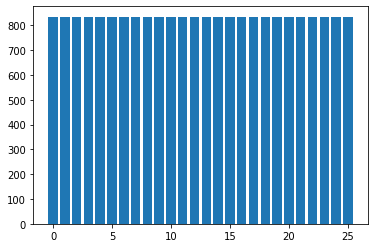

In [33]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [34]:
asdfasda

NameError: name 'asdfasda' is not defined

In [ ]:
'============================================'

In [ ]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier


solvers = ['sgd', 'adam', 'lbfgs']
hidden_layer_sizes = [8,16,32,64,128,256,512]
alpha = [1e-5, 1e-6, 1e-7, 1e-8]
activations = ['identity', 'logistic', 'tanh', 'relu']
learning_rates = ['constant', 'invscaling', 'adaptive']
batch_sizes = [int(x) for x in np.linspace(start=200, stop=len(test_x), num=100)]


params={
    'solver':solvers,'hidden_layer_sizes':hidden_layer_sizes,'alpha':alpha,
    'activation':activations, 'learning_rate':learning_rates
    }

clf = MLPClassifier(random_state=1, early_stopping = True)

rcv= RandomizedSearchCV(clf, scoring=clf.score,param_distributions=params, n_iter=300, cv=5, 
                                random_state=42, n_jobs=-1, verbose = 10, return_train_score= True)

rcv.fit(train_x, train_y) ##training data on randomsearch cv
cv_best_params = rcv.best_params_ ##it will give you best parameters 
print(f"Best paramters: {cv_best_params}")  ##printing  best parameters

In [ ]:
# clf = MLPClassifier(solver='sgd', 
#                     alpha=1e-5,
#                     hidden_layer_sizes=(8,), 
#                     random_state=42,
#                     learning_rate='constant',
#                     activation='identity')

# clf.fit(train_x, train_y)     

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-7,
                    hidden_layer_sizes=(512,), 
                    random_state=42,
                    learning_rate='constant',
                    activation='relu')

clf.fit(train_x, train_y)     

In [ ]:
from sklearn.metrics import accuracy_score

predictions_train = clf.predict(train_x)
predictions_test = clf.predict(test_x)
train_score = accuracy_score(predictions_train, train_y)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_y)
print("score on test data: ", test_score)

In [ ]:
asdasda

In [ ]:
'============================================'

In [35]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=1)

In [36]:
dataset = X.copy()
dataset['Balanced Labels'] = y
dataset['Balanced Labels - names'] = le.inverse_transform(y)

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier


In [38]:
clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-7,
                    hidden_layer_sizes=(512,), 
                    random_state=42,
                    learning_rate='constant',
                    activation='relu')

clf.fit(train_x, train_y)   

MLPClassifier(alpha=1e-07, hidden_layer_sizes=(512,), random_state=42,
              solver='lbfgs')

In [41]:
from sklearn.metrics import accuracy_score

predictions_train = clf.predict(train_x)
predictions_test = clf.predict(test_x)
train_score = accuracy_score(predictions_train, train_y)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_y)
print("score on test data: ", test_score)

score on train data:  0.7075297874953936
score on test data:  0.6184598378776713


In [39]:
reference_df = pd.DataFrame(clf.predict_proba(input_df), columns= le.classes_)

temp_list = []
for index, row in reference_df.iterrows():
    temp_list.append(row.sort_values(ascending=False)[:3].to_dict())
    # break

In [40]:
for index, value in zip(input_df_orig['Lead Name'], temp_list):
    print(f"Lead Name: {index}")
    print('===============Sales Rep Options:=================')
    for key in value:
        print(f"{key}:{value[key]}")
    print('\n')

Lead Name: Lori J Clemons, Esq.
===============Sales Rep Options:=================
Janine Scott:0.6411386387143627
Joshua Jordan:0.3222142760472951
Cheri Ramos:0.03094251462842039


Lead Name: Sadara DeVonne
===============Sales Rep Options:=================
Michael Novi:0.7023643188515684
Dana Sirolli:0.2969900558232866
Erik Martinez:0.0006028290201584664


Lead Name: Julie Krzeminski
===============Sales Rep Options:=================
Robert Proden:0.9132187393963946
Joshua Jordan:0.049100367589283545
Jerod Arreguini:0.03267844530602036


Lead Name: Thomas Cattani
===============Sales Rep Options:=================
Jerod Arreguini:0.3641920682455241
Dana Sirolli:0.19753011744398782
Michael Novi:0.15398851509696593


Lead Name: Michael Lagnado
===============Sales Rep Options:=================
Cheri Ramos:0.8600684311428444
Jerod Arreguini:0.053736119502072445
Dana Sirolli:0.051101530023063155


Lead Name: Alicia Ainsworth
===============Sales Rep Options:=================
Cheri Ramos:0

Rules:
1. If below 50, do not follow recommendation and use that lead to balance the distribution
    - Do not record in tracker
1. If you notice there is repeating recommended value. Take note and inform me
1. If the probability is less than 90 and the first recommended value received to much, you can assign it to the next rep
1. You can edit the active list to customize the output